# Exploratory Data Analysis and Preprocessing
Prepared by Aniruddh K B | Based on previous work by Shreyas Gupta, TA, AI511ML-2020


Why do EDA? 

1. It helps you identify what features are important and what features are not.
2. It helps you understand the quality of the data and if there's anything you need to do to fix that. 
3. You can often gain insights directly from the EDA even without fitting a model!


**IMPORTANT NOTE:** This aspect of ML is more art and less science and you often have to test different combinations e.g with skew removal/without skew removal etc. If you want to check if some process is useful, try with it and without it, both.
------------------------------------------

## 1. Skew

In several of our algorithms, we assume that the feature columns are normally distributed. However, many times, the data is actually skewed i.e there is an asymmetry in the distribution i.e The mean is shifted to the left or to the right or vice-versa. 

You cannot detect skew just by looking at the data -- you have to visualize it using histogram plots. 

For demo's sake, I use the following code to generate skewed data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn.preprocessing as preprocessing 

In [2]:
left_skewed_data = np.log(np.log(5 + np.random.normal(size=10000)))

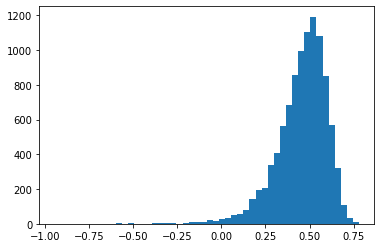

In [3]:
plt.hist(left_skewed_data, bins=50)
plt.show()

This skew can be problematic -- we assume our data to be Gaussian in nature, but it is clearly not the case! 

Left skew -- the left tail is thicker. 
RIght skew -- the right tail is thicker. 

To remove left skew, apply np.exp() successively to the data. 
To remove right skew, apply np.log() successively to the data. 

WARNING: Log is not defined for negative numbers. Add a constant or do something like that.

Intuition: When you apply the EXP, if you look at the data to the right, the increase of those points is much much more than the increase in the points to the left. So the right part "spreads out" more than the left part -- thus eliminating the left skew. 

When you apply the log, the reverse happens.

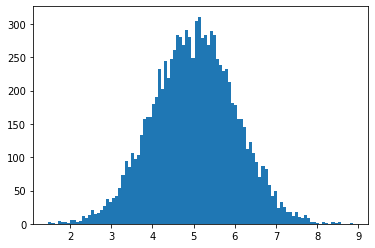

In [4]:
new_data = np.exp(np.exp(left_skewed_data))

plt.hist(new_data, bins=100)
plt.show()

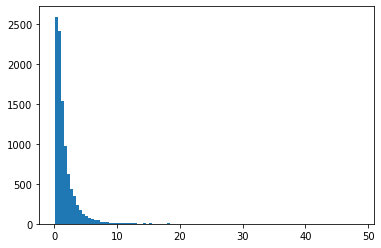

In [5]:
right_skewed_data = np.exp(np.random.normal(size=10000))
plt.hist(right_skewed_data, bins=100)
plt.show()

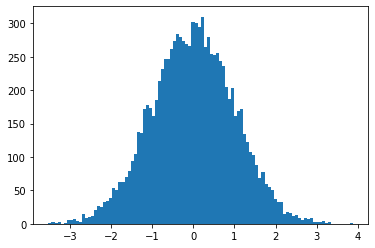

In [6]:
new_data = np.log(right_skewed_data)
plt.hist(new_data, bins=100)
plt.show()

You can also implement skew removal using the square and the square root (again, assuming all your data is positive !). Think -- which one removes which skew?

## 2. Normalisation and standardisation

The objective is to have features that are all in the same order of magnitude/scale. The reason for this is that if different features have different magnitudes, so will the gradients/slopes in those dimensions -- in fact the cost surface itself becomes very skewed. 

The end result of this is that we would need to use a small learning rate AND have many iterations. In fact, in extreme cases (like generation of polynomial features) we can see this making training impossible without normalisation or standardisation.


There are two approaches here:

1. min max normalisation 
2. standardization using mean and variance (also known as Z transformation)

You can read online for more information.

In [8]:
beers_df = pd.read_csv("./datasets/beers.csv")

In [9]:
beers_df.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [10]:
abv = 1000*beers_df["abv"]

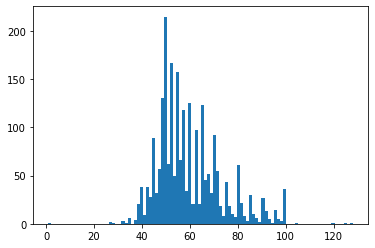

In [11]:
plt.hist(abv, bins=100)
plt.show()

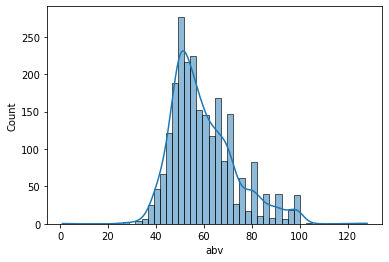

In [12]:
sns.histplot(abv, kde=True, line_kws={"color":"red"})
plt.show()

In [13]:
class MinMaxScaler:
    def __init__(self, minimum_elem, maximum_elem):
        self.minimum_elem = minimum_elem 
        self.maximum_elem = maximum_elem 
    
    def scale(self, x):
        return (x - self.minimum_elem)/(self.maximum_elem - self.minimum_elem)

In [14]:
abv_min_max_scaler = MinMaxScaler(abv.min(), abv.max())

In [15]:
min_max_scaled_abv = abv.apply(abv_min_max_scaler.scale)  

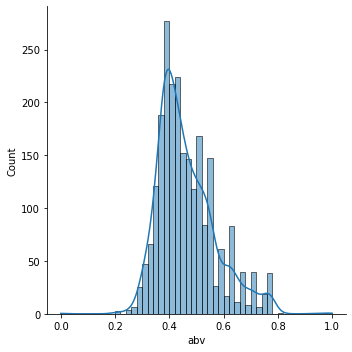

In [16]:
sns.displot(min_max_scaled_abv,kde=True )
plt.show()

In [17]:
class Standardizer: 
    def __init__(self, mean, stdev):
        self.mean = mean 
        self.stdev = stdev
    def scale(self, x):
        return (x - self.mean)/self.stdev

In [18]:
standardized_abv = abv.apply(Standardizer(abv.mean(), abv.std()).scale)  

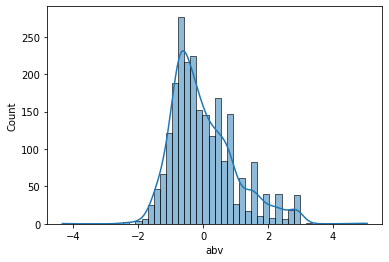

In [19]:
sns.histplot(standardized_abv, kde=True)
plt.show()

In general, though, you can usually use sklearn.preprocessing.StandardScaler

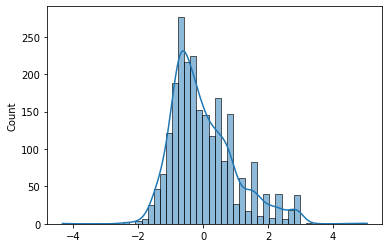

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_abv = scaler.fit_transform(abv.to_numpy().reshape(-1, 1)).reshape(-1)

sns.histplot(standardized_abv, kde=True)
plt.show()

## 3. Outlier detection and removal

Outliers are points in the dataset that are clearly outside the given distribution. They can occur due to a variety of reasons, but the point is that the point is clearly "wrong" in some sense. 

Outlier removal is important because, again, outliers can distort the distributions and can cause the model to learn the wrong thing. 

Again, this is pretty qualitative in nature and requires analysis of the data using various plots.

The first tool is the scatter plot.

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

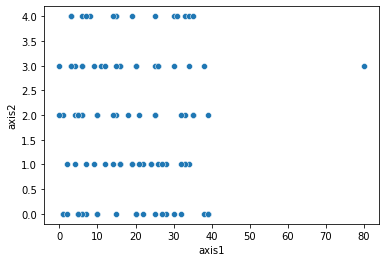

In [21]:
testd1 = np.random.randint(40, size=100)
testd2 = np.random.randint(5, size=100)
testnew = np.vstack((testd1, testd2))
norm = pd.DataFrame(testnew.transpose(), columns=['axis1', 'axis2'])
outlier = pd.DataFrame({"axis1": [80], "axis2":[3]})
final = norm.append(outlier, ignore_index = True)
sns.scatterplot(x = final.axis1, y = final.axis2)

In [23]:
avo_df = pd.read_csv("./datasets/avocado.csv")

In [24]:
avo_df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


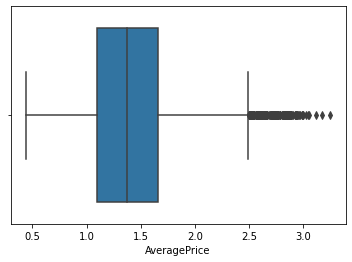

In [25]:
sns.boxplot(x=avo_df["AveragePrice"])
plt.show()

The above plot is a boxplot. The median is the central line in the box, while the left and right sides of the box are 25%-ile (lower quartile) and 75%-ile (upper quartile) . That range from 25%ile to 75%ile is known as the InterQuartile Range (IQR). The two whiskers extend from the respective quartile to 1.5 times the IQR. 

The points which lie outside the whiskers are highlighted and _potentially_ represent outliers. 

What you do with these points is completely up to you depending on the problem. 

Things to consider: How many points are there outside the whiskers? 

Are the points displaying some new behaviour in the output? Do we wish to capture this new behaviour or do we wish to remove them?

For illustration's sake, I show the procedure for rescaling the outlier points appropriately. You could also choose to remove them from the dataset if you have reason to believe that the outliers represent data errors, or you could ignore them if you feel they are important or if they won't impact the training.

In [26]:
class OutlierRemoval: 
    def __init__(self, lower_quartile, upper_quartile):
        self.lower_whisker = lower_quartile - 1.5*(upper_quartile - lower_quartile)
        self.upper_whisker = upper_quartile + 1.5*(upper_quartile - lower_quartile)
    def removeOutlier(self, x):
        return (x if x <= self.upper_whisker and x >= self.lower_whisker else (self.lower_whisker if x < self.lower_whisker else (self.upper_whisker)))

In [27]:
avg_price = avo_df["AveragePrice"]

In [28]:
avg_price.describe()

count    18249.000000
mean         1.405978
std          0.402677
min          0.440000
25%          1.100000
50%          1.370000
75%          1.660000
max          3.250000
Name: AveragePrice, dtype: float64

In [29]:
avg_price_outlier_remover = OutlierRemoval(avg_price.quantile(0.25), avg_price.quantile(0.75))

In [30]:
outlier_removed_avg_price = avg_price.apply(avg_price_outlier_remover.removeOutlier)

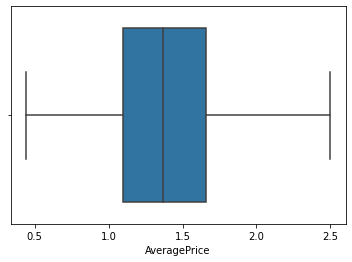

In [31]:
sns.boxplot(x=outlier_removed_avg_price)
plt.show()

Another interesting topic is categorical plots -- there's a whole section about it in Seaborn's documentation at https://seaborn.pydata.org/tutorial/categorical.html . Please do have a look! Also look at countplots for categorical features.

Some examples are given below: 

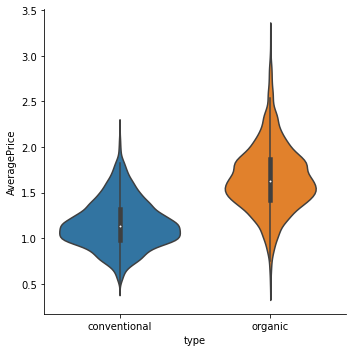

In [32]:
sns.catplot(kind="violin",x="type", y="AveragePrice", data=avo_df)
plt.show()

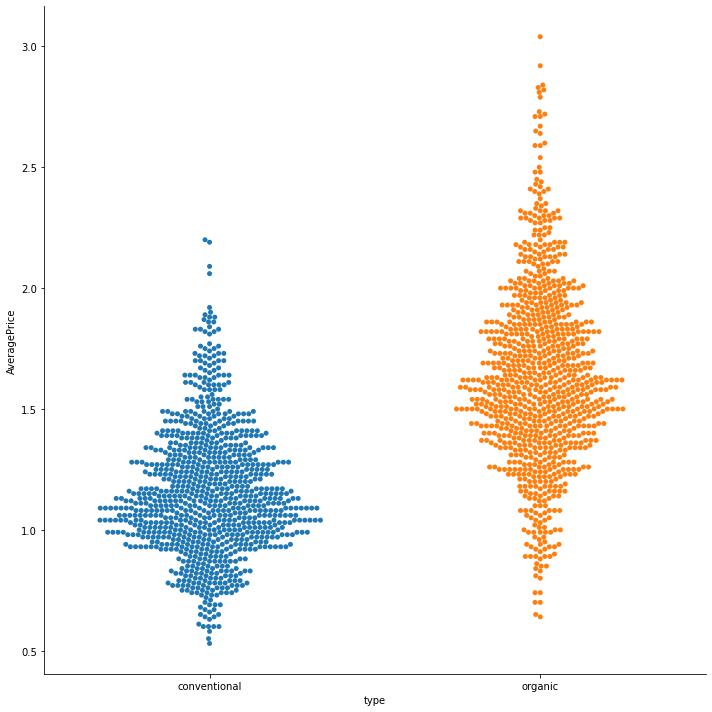

In [33]:
sns.catplot(kind="swarm",x="type", y="AveragePrice", data=avo_df.iloc[::10,:], height=10, aspect=1)
plt.show()

## 4. Correlation

Correlation between different feature columns can be a tricky thing because in multiple types of models, we assume that **features are independent**. In fact, in closed-form linear regression, when we invert X.T X , we cannot do so if the features in X.T are linearly dependent.

A common tool to detect correlation **strictly for comparing continuous features** is the correlation matrix. For categorical features/ categorical with continuous, you can use other methods as described in the below links: 

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365 

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9


https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab



In [34]:
avo_df_continuous = avo_df.drop(columns=["Unnamed: 0", "type", "year", "region", "Date"])

In [35]:
avo_df_continuous.corr()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
AveragePrice,1.000000,-0.192752,-0.208317,-0.172928,-0.179446,-0.177088,-0.174730,-0.172940,-0.117592
Total Volume,-0.192752,1.000000,0.977863,0.974181,0.872202,0.963047,0.967238,0.880640,0.747157
4046,-0.208317,0.977863,1.000000,0.926110,0.833389,0.920057,0.925280,0.838645,0.699377
4225,-0.172928,0.974181,0.926110,1.000000,0.887855,0.905787,0.916031,0.810015,0.688809
4770,-0.179446,0.872202,0.833389,0.887855,1.000000,0.792314,0.802733,0.698471,0.679861
Total Bags,-0.177088,0.963047,0.920057,0.905787,0.792314,1.000000,0.994335,0.943009,0.804233
Small Bags,-0.174730,0.967238,0.925280,0.916031,0.802733,0.994335,1.000000,0.902589,0.806845
Large Bags,-0.172940,0.880640,0.838645,0.810015,0.698471,0.943009,0.902589,1.000000,0.710858
XLarge Bags,-0.117592,0.747157,0.699377,0.688809,0.679861,0.804233,0.806845,0.710858,1.000000


<AxesSubplot:>

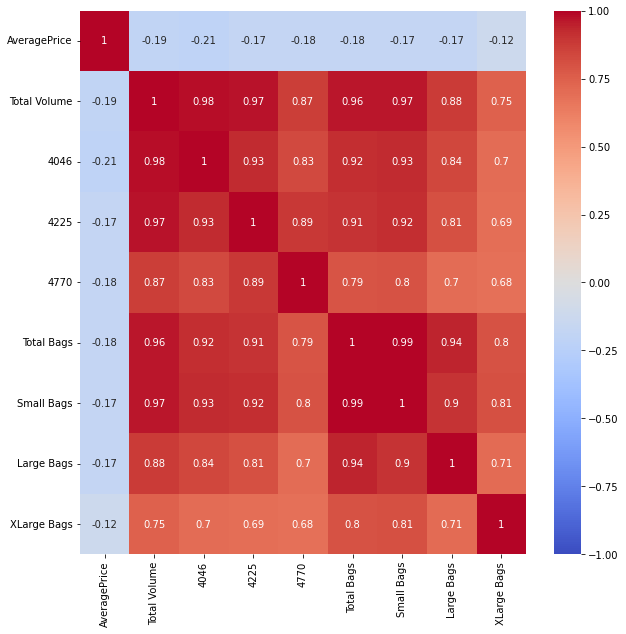

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(avo_df_continuous.corr(), vmin=-1, cmap="coolwarm", annot=True)

By default, df.corr() uses the Pearson correlation which is explained further at https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/ . 

In general, a correlation of 1 means perfect linear dependence (positive) and -1 means perfect linear dependence (negative). 0 means no correlation. 

You should try to remove highly correlated columns. 

Also try to observe which columns have next to no correlation with the output (for regression). You could also try creating various categorical plots to see if there is any change in the distribution of the continuous feature grouped by the categorical target (for classification).

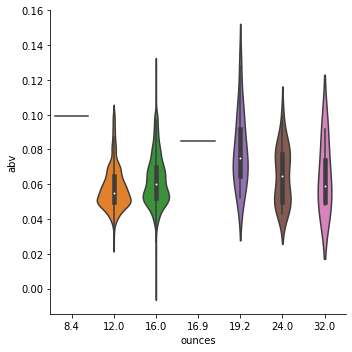

7

In [37]:
sns.catplot(x="ounces", y="abv", kind="violin", data=beers_df)
plt.show()

beers_df.ounces.nunique()